In [ ]:
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [ ]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'

# Visualizing Data

In [ ]:
# Function to plot images in the dataset
def plot_images(path, labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(10, 6))

    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if amount == max_images:
                break

            img = mpimg.imread(os.path.join(path, file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img)

            amount += 1

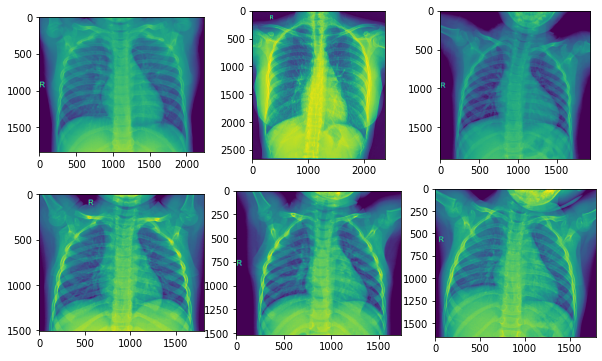

In [ ]:
plot_images(training_dir + '/NORMAL')

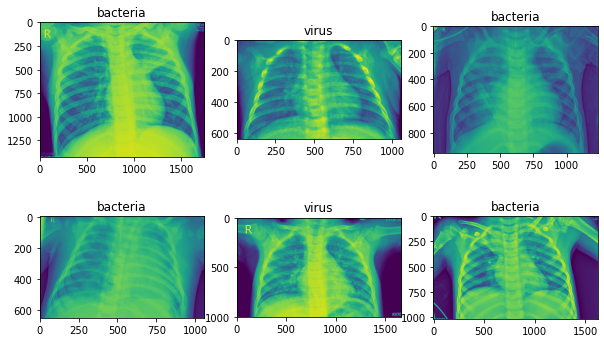

In [ ]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

# Image Preprocessing

In [ ]:
# Preprocessing the image with VGG16 preprocessing function
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=training_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 10)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=validation_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 10)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 1, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Fine Tuned model VGG16

In [ ]:
# downloading the VGG16 model
vgg16_model = VGG16() 

In [ ]:
# Summary of the VGG16 model
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Creating the model simialr to VGG16 by leaving the last layer of the VGG16 model
# As last layer of the VGG16 model have 1000 classes
# We only need two classes to predict wheather Pnemonia or Normal
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
# Summary of the newly creaetd model same as VGG16
# without last layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
# Freezing top layers
# So that they were not involved in training
for layer in model.layers:
    layer.trainable = False

In [ ]:
# adding a dense layer at the output
# activaition = relu
model.add(Dense(2, activation = 'softmax'))

In [ ]:
# summary of the newly created model
# after adding output layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# Train the fine-tuned VGG16 Model

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_batches, validation_data = valid_batches, epochs = 5, verbose = 1)

Epoch 1/5
522/522 [==============================] - 58s 111ms/step - loss: 0.2595 - accuracy: 0.8944 - val_loss: 0.5013 - val_accuracy: 0.8125
Epoch 2/5
522/522 [==============================] - 58s 111ms/step - loss: 0.1312 - accuracy: 0.9507 - val_loss: 0.2729 - val_accuracy: 0.8750
Epoch 3/5
522/522 [==============================] - 58s 111ms/step - loss: 0.1098 - accuracy: 0.9595 - val_loss: 0.2719 - val_accuracy: 0.8750
Epoch 4/5
522/522 [==============================] - 58s 111ms/step - loss: 0.0966 - accuracy: 0.9641 - val_loss: 0.3632 - val_accuracy: 0.8125
Epoch 5/5
522/522 [==============================] - 58s 111ms/step - loss: 0.0853 - accuracy: 0.9686 - val_loss: 0.2097 - val_accuracy: 0.8750


# Learning Curves

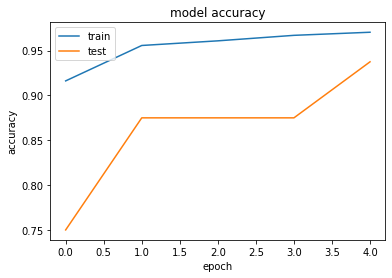

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

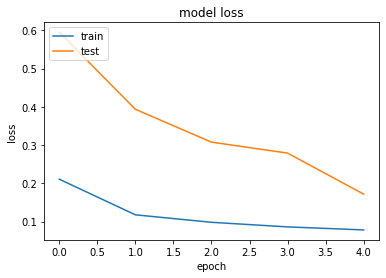

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate the trained fine-tuned VGG16 model

In [ ]:
result  = model.evaluate(test_batches, steps=len(test_batches), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

63/63 [==============================] - 6s 97ms/step - loss: 0.4916 - accuracy: 0.8317
Loss: 0.49156370759010315
Accuracy: 0.8317307829856873


In [ ]:
# Predicting the model against test batches
predictions = model.predict(x = test_batches, verbose = 0)

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color = "white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[159  75]
 [  6 384]]


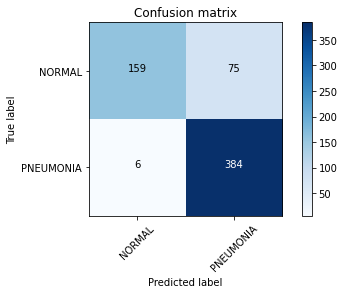

In [ ]:
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion matrix")

# Classification Report

In [ ]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_batches)):
    y_img_batch, y_true_batch = test_batches[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)


In [ ]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(y_true_batches, y_pred_batches, target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       0.96      0.57      0.72       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



In [49]:
# saving the model for deployment purpose
model.save('PneumoniaDetection_model.h5')